In [ ]:
# %matplotlib qt
# %matplotlib ipympl

In [1]:
## Imports
print("Importing...")
import re
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import easyocr

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.widgets import Slider


Importing...


In [2]:
########################################################
##########               INPUTS               ##########
########################################################

VIDEO_PATH = r"Examples\Not_processed\Video.avi"
# VIDEO_PATH = None
rules = dict(re_rule=r'-?\d{1,3}\.\d', )
RECOGNIZABLE_VARIABLES = [
    dict(name='Viscosity', rules=rules),
    dict(name='Temperature', rules=rules),
]


In [3]:
## Global settings
if VIDEO_PATH is None:
    input_path = ''
    while input_path == '':
        input_path = input(f"Input video path: ")
    VIDEO_PATH = input_path

CAP = cv2.VideoCapture(VIDEO_PATH)
FPS = int(CAP.get(cv2.CAP_PROP_FPS))
LENTH = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / FPS)
CAP.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, START_FRAME = CAP.read()


In [4]:
%matplotlib qt

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
fig.subplots_adjust(left=0.25, right=1, bottom=0.25, top=1, hspace=0, wspace=0)
ax_time_slider = fig.add_axes([0.25, 0.1, 0.65, 0.03])
a= Slider(
            ax=ax_time_slider,
            label='blur',
            valmin=0,
            valmax=20,
            valinit=0,
            valstep=1,
        )
plt.show()

In [25]:
## Image processor
class ImageProcessor:
    variables = []
    _parametr_configurations = []
    _parametrs = {}

    def configure_process(
        self,
        video_capture,
        start_frame: int = 0,
        end_frame: int = 0,
    ):

        def update():
            time = TIME_slider.val
            video_capture.set(cv2.CAP_PROP_POS_FRAMES, int(fps * time))
            _, frame = video_capture.read()

            for slider in sliders:
                slider_name = str(slider.label).split("'")[1]
                self[slider_name] = slider.val

            frame = self.process(frame)
            plot.set_data(frame)
            plot.autoscale()
            fig.canvas.draw_idle()

        fig, ax = plt.subplots()
        fig.set_size_inches(15, 15)
        fig.subplots_adjust(
            left=0.25,
            right=1,
            bottom=0.25,
            top=1,
            hspace=0,
            wspace=0,
        )
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
        _, start_frame = video_capture.read()
        fps = int(CAP.get(cv2.CAP_PROP_FPS))
        video_len = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / fps)
        plot = ax.imshow(self.process(start_frame), cmap='binary')

        time_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
        fps = int(CAP.get(cv2.CAP_PROP_FPS))
        max_len = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / fps)
        max_n_frame = max_len if not end_frame else end_frame - 1
        min_n_frame = 0 if not start_frame else start_frame
        TIME_slider = Slider(
            ax=time_slider_ax,
            label='Time',
            valmin=min_n_frame,
            valmax=max_n_frame,
            valinit=min_n_frame,
            valstep=1,
        )

        sliders = []
        ofset = 0.2
        for parametr, diap in self._parametr_configurations.items():
            slider_ax = fig.add_axes([ofset, 0.25, 0.03, 0.6])

            p_min = min(diap)
            p_max = max(diap)
            p_step = (max(diap) - min(diap)) / (len(diap) - 1)

            slider = Slider(
                ax=slider_ax,
                orientation='vertical',
                label='Blur',
                valmin=p_min,
                valmax=p_max,
                valinit=p_min,
                valstep=p_step,
            )
            slider.on_changed(update)
            sliders.append(slider)
            ofset -= 0.02

        print('Configurate image processing')
        plt.show()

    def select_window(self, image):
        for variable in self.variables:
            processed_image = self.process(image)
            processed_image = cv2.bitwise_not(processed_image)
            # TODO: make border color=red
            window = cv2.selectROI(
                f"Select {variable['name']}",
                processed_image,
                fromCenter=False,
                showCrosshair=True,
            )
            variable['slice'] = window
        cv2.destroyAllWindows()

    def check_process(
        self,
        video_capture,
        start_frame: int = 0,
        end_frame: int = 0,
    ):

        def update():
            time = TIME_slider.val
            video_capture.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
            _, frame = video_capture.read()
            plot.set_data(self.process(frame))
            plot.autoscale()
            fig.canvas.draw_idle()

        fig, ax = plt.subplots()
        fig.set_size_inches(15, 15)
        fig.subplots_adjust(
            left=0.25,
            right=1,
            bottom=0.25,
            top=1,
            hspace=0,
            wspace=0,
        )
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
        _, start_frame = video_capture.read()

        plot = ax.imshow(self.process(start_frame), cmap='binary')

        time_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
        fps = int(CAP.get(cv2.CAP_PROP_FPS))
        max_len = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / fps)
        max_n_frame = max_len if not end_frame else end_frame - 1
        min_n_frame = 0 if not start_frame else start_frame
        TIME_slider = Slider(
            ax=time_slider_ax,
            label='Time',
            valmin=min_n_frame,
            valmax=max_n_frame,
            valinit=min_n_frame,
            valstep=1,
        )
        plt.show()

    @staticmethod
    def strict(image, x, y, w, h):
        return image[y:y + h, x:x + w]

    def process(self):
        raise NotImplementedError

    def __init__(self):
        all_fields = dict(self.__class__.__dict__)
        self._parametr_configurations = {
            key: value
            for key, value in all_fields.items()
            if key[0].isupper()
        }
        self._parametrs = {
            key: min(value)
            for key,
            value in self._parametr_configurations.items()
        }

    def __getitem__(self, item):
        return self._parametrs[item]

    def __setitem__(self, item, value):
        self._parametrs[item] = value

    def __call__(self, image):
        return self.process(image)


In [33]:
not 0

True

In [26]:
class TestProc(ImageProcessor):
    Blur = range(1, 50)
    
    variables = [
    dict(name='Viscosity', rules=rules),
    dict(name='Temperature', rules=rules),
]
    def process(self, image):
        image = cv2.blur(image, (self['Blur'], self['Blur']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.bitwise_not(image)
        return image

In [27]:
test_proc= TestProc()

In [30]:
plt.imshow(test_proc.process(START_FRAME),cmap='binary')

In [31]:
test_proc.configure_process(CAP)

AttributeError: 'TestProc' object has no attribute 'video_len'

In [ ]:
## Setup processor confings
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.25, right=1, bottom=0.25, top=1, hspace=0, wspace=0)

image_processor = lambda x:x
PLOT = ax.imshow(image_processor(START_FRAME), cmap='binary')

ax_time_slider = fig.add_axes([0.25, 0.1, 0.65, 0.03])
TIME_slider = Slider(
    ax=ax_time_slider,
    label='Time',
    valmin=0,
    valmax=LENTH,
    valinit=0,
    valstep=1,
)

ax_blur_slider = fig.add_axes([0.1, 0.25, 0.03, 0.6])
BLUR_slider = Slider(
    ax=ax_blur_slider,
    orientation='vertical',
    label='Blur',
    valmin=1,
    valmax=50,
    valinit=1,
    valstep=1,
)


def update(val):
    time = TIME_slider.val
    global image_processor
    print(BLUR_slider.val)

    CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
    _, frame = CAP.read()
    frame = image_processor(frame)

    PLOT.set_data(frame)
    PLOT.autoscale()

    fig.canvas.draw_idle()


TIME_slider.on_changed(update)
BLUR_slider.on_changed(update)
print('Configurate image processing')
plt.show()

In [5]:
def foo():
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 3)
    fig.subplots_adjust(left=0.2, right=0.95, bottom=0.05, top=1, hspace=0, wspace=0)

    image_processor = lambda x:x
    PLOT = ax.imshow(image_processor(START_FRAME), cmap='binary')

    ax_time_slider = fig.add_axes([0.2, 0.05, 0.7, 0.05])
    TIME_slider = Slider(
        ax=ax_time_slider,
        label='Time',
        valmin=0,
        valmax=LENTH,
        valinit=0,
        valstep=1,
    )

    ax_blur_slider = fig.add_axes([0.15, 0.25, 0.02, 0.6])
    BLUR_slider = Slider(
        ax=ax_blur_slider,
        orientation='vertical',
        label='Blur',
        valmin=1,
        valmax=50,
        valinit=1,
        valstep=1,
    )


    def update(val):
        time = TIME_slider.val
        print(BLUR_slider.val)

        CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
        _, frame = CAP.read()
        frame = image_processor(frame)

        PLOT.set_data(frame)
        PLOT.autoscale()

        fig.canvas.draw_idle()


    TIME_slider.on_changed(update)
    BLUR_slider.on_changed(update)
    print('Configurate image processing')
    plt.show()
    fig, ax = plt.subplots()
    ax.plot([1,23,4])
    return ax

def foo2():
    foo()
    print('ffffff')

Configurate image processing


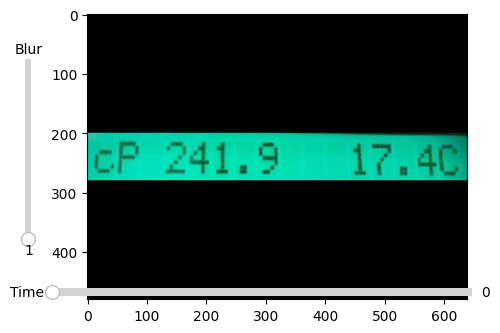

<Axes: >

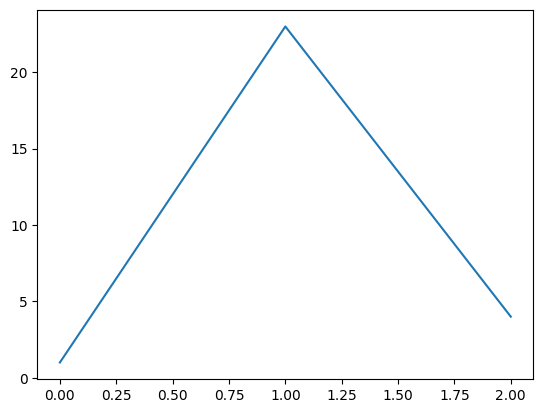

In [6]:
foo()

In [47]:
y = plt.figure()
y.add_axes(h)
plt.show()

ValueError: The Axes must have been created in the present figure

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.05, top=1, hspace=0, wspace=0)

image_processor = lambda x:x
PLOT = ax.imshow(image_processor(START_FRAME), cmap='binary')

ax_time_slider = fig.add_axes([0.2, 0.05, 0.7, 0.05])
TIME_slider = Slider(
    ax=ax_time_slider,
    label='Time',
    valmin=0,
    valmax=LENTH,
    valinit=0,
    valstep=1,
)

ax_blur_slider = fig.add_axes([0.15, 0.25, 0.02, 0.6])
BLUR_slider = Slider(
    ax=ax_blur_slider,
    orientation='vertical',
    label='Blur',
    valmin=1,
    valmax=50,
    valinit=1,
    valstep=1,
)


def update(val):
    time = TIME_slider.val
    print(BLUR_slider.val)

    CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
    _, frame = CAP.read()
    frame = image_processor(frame)

    PLOT.set_data(frame)
    PLOT.autoscale()

    fig.canvas.draw_idle()


TIME_slider.on_changed(update)
BLUR_slider.on_changed(update)
print('Configurate image processing')
plt.show()


Configurate image processing


6
7
13
18
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19


In [45]:
h= foo()

Configurate image processing


12
13
15
17
18
17
17
17
17
17
17
17
17


In [ ]:
n= plt.plot([1,2,3,4,5])
plt.show()

In [ ]:
plt.
plt.plot([1,23,4,56,4,5,6,77,5])
plt.show()

In [ ]:
## Selection
def strict(image, x, y, w, h):
    return image[y:y + h, x:x + w]


print(f'Blur value= {image_processor.blur}')
for variable in RECOGNIZABLE_VARIABLES:
    roi_frame = image_processor(START_FRAME)
    roi_frame = cv2.bitwise_not(roi_frame)
    current_slice = cv2.selectROI(
        f"Select {variable['name']}",
        roi_frame,
        fromCenter=False,
        showCrosshair=True,
    )
    variable['slice'] = current_slice
cv2.destroyAllWindows()

# Result plots
fig, axes = plt.subplots(nrows=len(RECOGNIZABLE_VARIABLES))
# fig.set_t
if not isinstance(axes, np.ndarray): axes = [axes]
fig.set_size_inches(3, 1 * len(RECOGNIZABLE_VARIABLES))
fig.subplots_adjust(left=0, right=1, bottom=0.0, top=1, hspace=0, wspace=0)
start_slices = [
    strict(image_processor(START_FRAME), *variable['slice'])
    for variable in RECOGNIZABLE_VARIABLES
]
for i in range(len(RECOGNIZABLE_VARIABLES)):
    axes[i].set_axis_off()
    axes[i].imshow(start_slices[i], cmap='binary')
plt.show()

In [ ]:
class ValueChecker:

    def check(self, image, raw_value, rules):
        pattern_check = self._pattern_check(raw_value, **rules)
        if pattern_check is not None: return 0, pattern_check

        img_check = self._image_check(image, rules)
        if img_check is not None: return 1, img_check

        # value_check = self._value_check(raw_value)
        # if value_check is not None: return 2,value_check
        return 3, None

    def __init__(self, processor: ImageProcessor, reader):
        self._processor = copy.deepcopy(processor)
        self._reader = reader

    def _pattern_check(
        self,
        value: list,
        re_rule=None,
        min_rule=None,
        max_rule=None,
    ):  
        if value==[]: return None
        value = value[0]
        value = value.replace(',', '.')
        one_check = len(re.findall(re_rule, value)) == 1
        try:
            value = float(value)
        except ValueError:
            return None
        min_check = value <= min_rule if min_rule is not None else True
        max_check = value >= max_rule if max_rule is not None else True

        result = value if one_check and min_check and max_check else None
        return result
    def processor_configurator(self):
        for i in range(1,50):
            self._processor.blur=i
            yield True
        
    def _image_check(self, image, rules):
        configurator = self.processor_configurator()
        loop=True
        while loop:
            processed_img = self._processor(image=image)
            raw_value = [
                value for _, value, _ in self._reader.readtext(processed_img)
            ]
            
            result = self._pattern_check(raw_value, **rules)
            if result is not None:
                return result
            else:
                try:
                    loop = configurator.__next__()
                except StopIteration:
                    return None
                

    def _value_check(self, raw_value: list):
        parts = len(raw_value)
        if parts == 1:
            try:
                check_result = float(raw_value[0])
                if check_result > 1000:
                    raw_result = str(check_result)
                    raw_result = raw_result[:3] + '.' + raw_result[4]
            except:
                raw_result = None

        elif parts == 2:
            raw_result = '.'.join(raw_value)

        elif parts == 3:
            raw_result = f'{raw_value[0]}.{raw_value[2]}'

        try:
            result = float(raw_result)
        except:
            result = None
        return result


In [ ]:
## Recognize
print('Starting recognizer...')
reader = easyocr.Reader(['en'])
checker = ValueChecker(reader=reader, processor=image_processor)

input_fps = input('Input number of frames per second: ')
try:
    read_fps = float(input_fps)
except:
    read_fps = 1

print('Recognizing:')
errors = 0
frame_line = tqdm(iterable=range(0, FPS * LENTH, int(FPS / read_fps)))
frame_line.set_description(f'Errors: {errors: >4}')
data = []
for i_frame in frame_line:
    CAP.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    _, frame = CAP.read()
    i_text = {'time': round(i_frame / FPS, 1)}
    for variable in RECOGNIZABLE_VARIABLES:
        selection = strict(frame, *variable['slice'])
        processed_img = image_processor(selection)
        raw_value = [value for _, value, _ in reader.readtext(processed_img)]
        
        mark, result = checker.check(image=selection,
                               raw_value=raw_value,
                               rules=variable['rules'])
        i_text[variable['name']] = result
        i_text[variable['name']+'_mark'] = mark

    if None in i_text.values():
        errors += 1
        frame_line.set_description(f'Errors: {errors: >4}')
    data.append(i_text)


In [ ]:
## Print
print(pd.DataFrame(data))